In [ ]:
!pip install pretty-confusion-matrix
!pip install transformers
!pip install pytorch-transformers
!pip install -U sentence-transformers
!pip install matplotlib==3.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 73 kB 1.3 MB/s 
     |████████████████████████████████| 156 kB 11.0 MB/s 
     |████████████████████████████████| 11.2 MB 48.9 MB/s 
     |████████████████████████████████| 199 kB 62.6 MB/s 
     |████████████████████████████████| 103 kB 52.9 MB/s 
     |████████████████████████████████| 843 kB 49.5 MB/s 
     |████████████████████████████████| 68 kB 6.3 MB/s 
     |████████████████████████████████| 41 kB 514 kB/s 
     |████████████████████████████████| 965 kB 42.1 MB/s 
     |████████████████████████████████| 98 kB 7.8 MB/s 
     |████████████████████████████████| 8.8 MB 36.5 MB/s 
     |████████████████████████████████| 468 kB 49.8 MB/s 
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=71f463922d77a1ef1820332c564b33b9028af1e077ec9000d62a7e81807472b3
  Stored in directory: /root/.cache/pip/wheels/42/56/cc/4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.2 MB/s 
     |████████████████████████████████| 7.6 MB 40.9 MB/s 
     |████████████████████████████████| 163 kB 76.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 176 kB 4.8 MB/s 
     |████████████████████████████████| 132 kB 47.6 MB/s 
     |████████████████████████████████| 880 kB 50.5 MB/s 
     |████████████████████████████████| 1.3 MB 40.1 MB/s 
     |████████████████████████████████| 9.9 MB 42.9 MB/s 
     |████████████████████████████████| 79 kB 8.8 MB/s 
     |████████████████████████████████| 140 kB 43.5 MB/s 
     |████████████████████████████████| 127 kB 49.7 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895259 sha256=890885dabe3fe8dc2c6eb0bcd2510c5eca634d3892c95c55c989365456a8c977
  Stored

In [ ]:
import numpy as np 
import pandas as pd 
import csv
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
NUM_OF_ASPECTS = 7
EPOCHS = 2
LSTM_UNITS = 256
MAXLEN = 768

## ADD PATH OF THE PRE-TRAINED MODEL HERE ##
LOAD_PATH = './MultiTask-OurModel-BiLSTM_256-epoch150.h5'

## LOAD DATA

In [ ]:
# LOAD EMBEDS DATASET
import pickle

# REVIEWS
with open('/content/drive/MyDrive/IITP/reviews_train.pickle', 'rb') as handle:
    reviews_train = pickle.load(handle)
    handle.close()

with open('/content/drive/MyDrive/IITP/reviews_test.pickle', 'rb') as handle:
    reviews_test = pickle.load(handle)
    handle.close()

# SCIBERT EMBEDS
with open('/content/drive/MyDrive/IITP/sci_embeds_test.pickle', 'rb') as handle:
    embeds_test = pickle.load(handle)
    handle.close()

# LABELS
with open('/content/drive/MyDrive/IITP/y_ohe_test.pickle', 'rb') as handle:
    y_ohe_test = pickle.load(handle)
    handle.close()


In [ ]:
aspect_categories = y_ohe_test.columns[:-1]
y_ohe_test['polarity'] = np.where(y_ohe_test['polarity'] == -1, 0, 1)

## LOAD MODEL

In [ ]:
import tensorflow as tf
from keras.layers import Layer
from keras import backend as K

In [ ]:
class Attention(Layer):
    
    def __init__(self, return_sequences=True, **kwargs):
        super(Attention,self).__init__()
        self.return_sequences = return_sequences
        super(Attention, self).__init__(**kwargs)

    def get_config(self):
        config = super(Attention, self).get_config().copy()
        config.update({
            'return_sequences': self.return_sequences , 
        })
        return config


    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(Attention,self).build(input_shape)
        
    def call(self, x):

        e =K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        a =K.softmax(e)
        a=K.expand_dims(a,axis=-1)
        output = x*a
        
        return K.sum(output, axis=1) 

In [ ]:
# LOAD MODEL
from keras.models import load_model
model = load_model(LOAD_PATH, custom_objects={'Attention': Attention})

print("MODEL LOADED\n\n")

model.evaluate(embeds_test, [y_ohe_test[aspect_categories].values, y_ohe_test.polarity.values] )

MODEL LOADED


1260/1260 [==============================] - 30s 23ms/step - loss: 1.0944 - CATEGORY_OUTPUT_loss: 0.9417 - POLARITY_OUTPUT_loss: 0.1528 - CATEGORY_OUTPUT_accuracy: 0.8806 - POLARITY_OUTPUT_accuracy: 0.9720


[1.0944466590881348,
 0.9416885375976562,
 0.15275819599628448,
 0.8805725574493408,
 0.9720410108566284]

## SCI-BERT MODEL 


In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModel

In [ ]:
embed_model_name = 'gsarti/scibert-nli'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(embed_model_name) 
embed_model = AutoModel.from_pretrained(embed_model_name)

Downloading:   0%|          | 0.00/135 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/222k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def sent2embed(model, sent):
    inputs = tokenizer(sent, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    return outputs

# SAMPLE SCIBERT
sent = ['This work studies the predictive uncertainty issue of deep learning models.']
outputs = sent2embed(embed_model, sent)
outputs[1].shape


torch.Size([1, 768])

In [ ]:
# PRE-PROCESS -- SCIBERT-EMBED
def sciBertEmbed(reviews, y_train, model):
    embed_arr = []
    start = reviews.index[0]
    for idx in range(len(reviews.index)):
        print(start + idx)
        outputs = sent2embed(model, reviews.loc[start+idx])
        embed_arr.append([outputs[1].detach().numpy()[0]])
    
    embed_train_arr = tf.stack(embed_arr)

    return embed_train_arr, y_train


## INFERENCE MODEL

In [ ]:
def predictPreprocess(model, sent):
  outputs = sent2embed(model, sent)
  pred_X = np.array([outputs[1].detach().numpy()[0]])
  embed_X = tf.stack([pred_X])
  return embed_X

In [ ]:
def inferenceModelForHeatmap(multi_model, embed_model, sents):
    labels = y_ohe_test.columns[:-1]
    cm_matrix = []
    results =[]
    for s in sents:
        test_embed = predictPreprocess(embed_model, s.strip())
        category_probab = multi_model.predict(test_embed)
        category_label_idx = np.argmax(category_probab[0])
        category_polarity = 1 if category_probab[1][0][0] > 0.5 else 0
        category_label = 'POS' if category_probab[1][0][0] > 0.5 else 'NEG'
        cm_matrix.append(category_probab[0][0])
        results.append([labels[category_label_idx] , category_polarity, category_label, category_probab[0][0] ])
        
    return results , np.array(cm_matrix)


In [ ]:
def cm_plotAttention(cm_matrix , title_txt, palette, annot=False):
  plt.figure(figsize=(13, 13))
  num_sents = cm_matrix.shape[0] +1

  sns.heatmap(cm_matrix.T, cmap= palette, yticklabels=aspect_categories, xticklabels=np.arange(1, num_sents),  annot=annot, fmt=".2f")

  plt.xlabel('Sentences', fontsize=17, labelpad=20)
  plt.ylabel('Aspect Categories', fontsize=17, labelpad=20)
  plt.tick_params(axis='both', which='major', labelsize=15)
  # title = 'Attention Visualization for ' + title_txt
  # plt.title(title)
  plt.show()


### SAMPLE 1

In [ ]:
# SAMPLE 1
review1 = [ 'This work proposes a framework for interpreting model behaviour by generating language descriptions of neurons in the model. The method is trained to maximize mutual information between the description and input examples that activate the neuron. The experiments show results for image classification, generation, and unsupervised representation learning. In particular, this method yields model description that achieve higher BERTScore than max-likelihood training when transferring to neurons in new architectures. Moreover the authors show how this technique can be used to compute correlations between descriptions and neuron importance (e.g. wrt classification accuracy), interpreting model behaviour (e.g. anonymized models still select for unblurred faces), and that one can remove spurious feature corrleations by removing models with specific descriptions.',
'Main Review: I want to preface my review by stating that I am a domain expert in NLP and not CV. While I attempted a preliminary search for related work, I am not sure if there is prior work in specifically generating language descriptions of neurons (I understand that there is prior work in explaining neuron behaviour by examining inputs that activate it). Hence I may significantly modify my review based on the response of my peer reviewers.', 
'This is a strong piece of work that clearly states its hypotheses and carefully designs experiments to test said hypotheses. The technical novel of the particular method is low, however I do not think that is the point of this work. What this paper does show is a novel way to interpret model behaviour, and allows for very useful downstream applications (e.g. fast filtering of neurons activated by a particular feature through text selection). I advocate for acceptance of this work, and propose some potential improvement. I do have some concerns about the scoping of this work. The title and description suggests a more general method, however experiments are purely based on images. I think the paper title should be more finely scoped (NL descriptions of Deep Image Features).' ,
'Summary Of The Review: Strong paper demonstrating how to generation descriptions of image features and how to use method to analyze model behaviour and filter out neurons by description.',
'Correctness: 3: Some of the paper’s claims have minor issues. A few statements are not well-supported, or require small changes to be made correct.' ,
'Technical Novelty And Significance: 3: The contributions are significant and somewhat new. Aspects of the contributions exist in prior work.' ,
'Empirical Novelty And Significance: 3: The contributions are significant and somewhat new. Aspects of the contributions exist in prior work.' ,
'Confidence: 4: You are confident in your assessment, but not absolutely certain. It is unlikely, but not impossible, that you did not understand some parts of the submission or that you are unfamiliar with some pieces of related work.']
op1 , cm_matrix1 = inferenceModelForHeatmap(model, embed_model, review1)

print('PREDICTED OUTPUT :', op1)
print('\n\nPREDICTED CM MATRIX :', cm_matrix1)


1/1 [==============================] - 0s 29ms/step
PREDICTED OUTPUT : [['SOU', 0, 'NEG', array([1.0798785e-24, 3.7884323e-17, 6.1916518e-01, 3.8083431e-01,
       0.0000000e+00, 5.9849958e-07, 3.3145890e-27], dtype=float32)], ['SUB', 0, 'NEG', array([2.5108565e-24, 9.5317363e-25, 2.9726408e-02, 9.7027361e-01,
       1.5644119e-24, 3.1473661e-14, 3.9861268e-17], dtype=float32)], ['SUB', 0, 'NEG', array([4.0334690e-01, 2.1854626e-06, 3.8656725e-07, 5.9664953e-01,
       1.8819100e-14, 1.7889073e-07, 8.0102944e-07], dtype=float32)], ['CMP', 1, 'POS', array([1.3623185e-30, 2.0610114e-23, 1.4230344e-12, 8.0214738e-07,
       8.4305628e-34, 9.9999917e-01, 1.2721833e-20], dtype=float32)], ['SOU', 0, 'NEG', array([2.0224108e-17, 1.2096986e-08, 9.8852962e-01, 1.3436947e-10,
       5.6341925e-08, 2.4384479e-12, 1.1470326e-02], dtype=float32)], ['ORI', 1, 'POS', array([5.0679879e-15, 1.0000000e+00, 4.2117016e-14, 1.7469012e-20,
       1.9429278e-15, 1.1203813e-25, 8.8455915e-17], dtype=float32)]

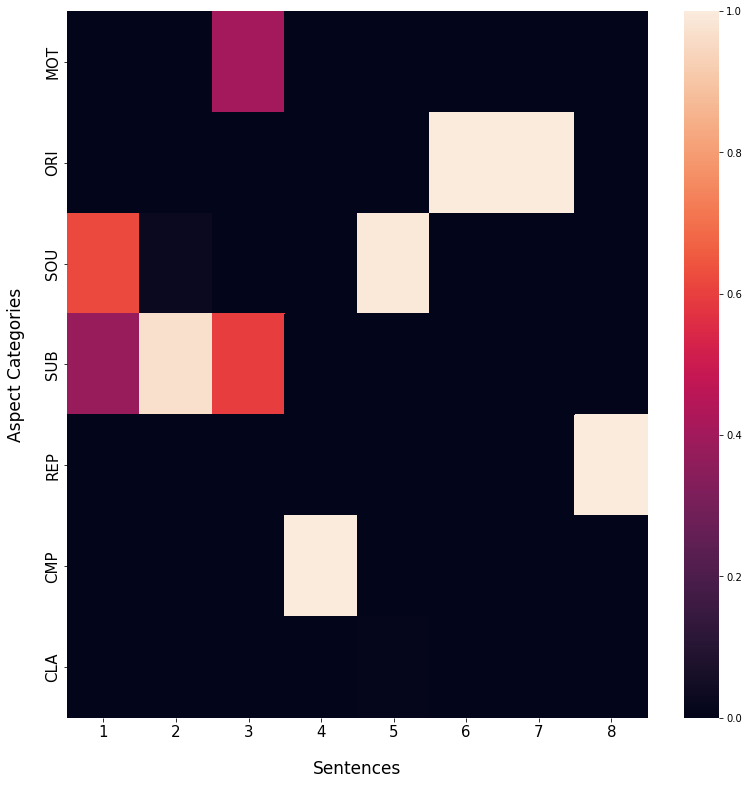

In [ ]:
# cm_plotAttention(cm_matrix1 , 'Review 1', "Greens")
cm_plotAttention(cm_matrix1 , 'Review 1', "rocket")

### SAMPLE 2

In [ ]:
# SAMPLE 2
review2 = ['Summary Of The Paper: This paper proposes ILQR-VAE, a novel method that allows to simultaneously learn latent dynamics and infer unobserved control inputs. The method relies on IQLR solver and recent advances allowing for implicit differentiation to maximize an Evidence Lower Bound on log-likelihood of observation to infer a conditional distribution over inputs as well as latent states. Authors show comparisons to other models (the closest one being LFADS) on toy datasets and benchmark datasets for neural data analysis methods. iLQR-VAE is on par with state-of-the-art methods on many datasets, does not require any extensive hyperparameter optimization, and allows for fast inference when dimension of the latent processes is not too high.',
'Main Review: Authors present a novel method for simultaneously learning latent dynamics and inferring unobserved control inputs. The method performs very well on several toy datasets (autonomous and input-driven linear dynamical system + Lorenz attractor), is on par with state of the art methods on benchmark datasets for neural data analysis methods, and allows for better reconstruction of hand kinematics for primate recordings in a continuous reaching task. The main novelty of the method lies in the utilization of iLQR with implicit differentiation. The paper also extensively discusses LFADS and provides very interesting insights on LFADS.',
"An important component of the method is the prior on input distribution. Authors show how to use a Gaussian prior or a multivariate Student prior (it allows for strong inputs when needed, represents the fact that inputs come as shared events and are spatially and temporally independent, and authors mention it might be one advantage over LFADS's autoregressive prior). This is a key idea of the paper and I would like to see more experiments highlighting the importance of the prior. I would recommend that the authors show (possibly in the appendix), the differences between the inferred inputs and performances when using different priors.",
"The derivation of the ELBO does not seem straightforward to me. To go from equation 7 to 8, don't you need to condition p(o|u) on z_0 as well? Maybe I am not correct, but I would appreciate if authors clarify this point (and correct the manuscript if needed)" ,
"About the computational complexity. The model is linear in T and cubic in n, which seems fast for low-dimensional latents only. Authors mention that iQLR-VAE enables fast learning of dynamics, but they also mention it as a limitation in the discussion. Could authors clarify this? Moreover, I believe the computational complexity comparison with LFADS in Figure 1 bottom left is not fair. Authors compare the number of training iteration without comparing the complexity of each iteration. I would like to see comparison for other datasets as well.",
"There are many performance metrics used in this paper to show that iQLR-VAE performs as well as other state of the art methods. However, there are no comparisons of the processes learnt by the different methods. Showing superimposed processes inferred by different methods (not only LFADS) for several experiments would allow to gain insight into the methods and how they compare (in term of uncertainty, smoothness, etc...). Similarly, for Figure 4, it would be interesting to see a low dimensional representation of neural activity (and comparisons of different methods). For this experiment, is it necessary to use a latent processes of dimension 50? Wouldn't it be sufficient and more efficient to use lower dimensional latent for this task?",
'Summary Of The Review: I recommend acceptance of the paper. This is a very interesting and novel method, that is shown to perform very well on several different datasets. There are many quantitative experiments but showing qualitative comparisons would be very beneficial for gaining insights into how different methods compare.',
'Correctness: 4: All of the claims and statements are well-supported and correct,' ,
'Technical Novelty And Significance: 4: The contributions are significant, and do not exist in prior works.',
'Empirical Novelty And Significance: 3: The contributions are significant and somewhat new. Aspects of the contributions exist in prior work.'
]

op2 , cm_matrix2 = inferenceModelForHeatmap(model, embed_model, review2)

print('PREDICTED OUTPUT :', op2)
print('\n\nPREDICTED CM MATRIX :', cm_matrix2)


1/1 [==============================] - 0s 21ms/step
PREDICTED OUTPUT : [['ORI', 1, 'POS', array([4.2847267e-12, 1.0000000e+00, 4.9497344e-09, 7.3901970e-19,
       1.9262216e-36, 3.0779054e-36, 8.0494586e-24], dtype=float32)], ['SUB', 1, 'POS', array([4.0431265e-03, 7.0762755e-05, 1.9156901e-10, 9.9588615e-01,
       2.3360650e-27, 2.2467882e-10, 2.4308546e-21], dtype=float32)], ['SUB', 0, 'NEG', array([1.6896921e-17, 8.8206655e-22, 1.8577980e-08, 9.9983954e-01,
       5.3532831e-25, 1.6047418e-04, 5.9475289e-19], dtype=float32)], ['CLA', 0, 'NEG', array([5.0527442e-20, 1.0699391e-27, 5.4716187e-13, 1.8190404e-29,
       1.1428409e-17, 7.2265286e-18, 1.0000000e+00], dtype=float32)], ['CLA', 0, 'NEG', array([5.8037936e-11, 4.0449070e-18, 6.0719245e-08, 4.0231610e-04,
       4.6811909e-13, 1.6676557e-03, 9.9792993e-01], dtype=float32)], ['CMP', 0, 'NEG', array([0.0000000e+00, 0.0000000e+00, 7.4281227e-35, 8.2276796e-11,
       7.5697879e-17, 1.0000000e+00, 0.0000000e+00], dtype=float32)]

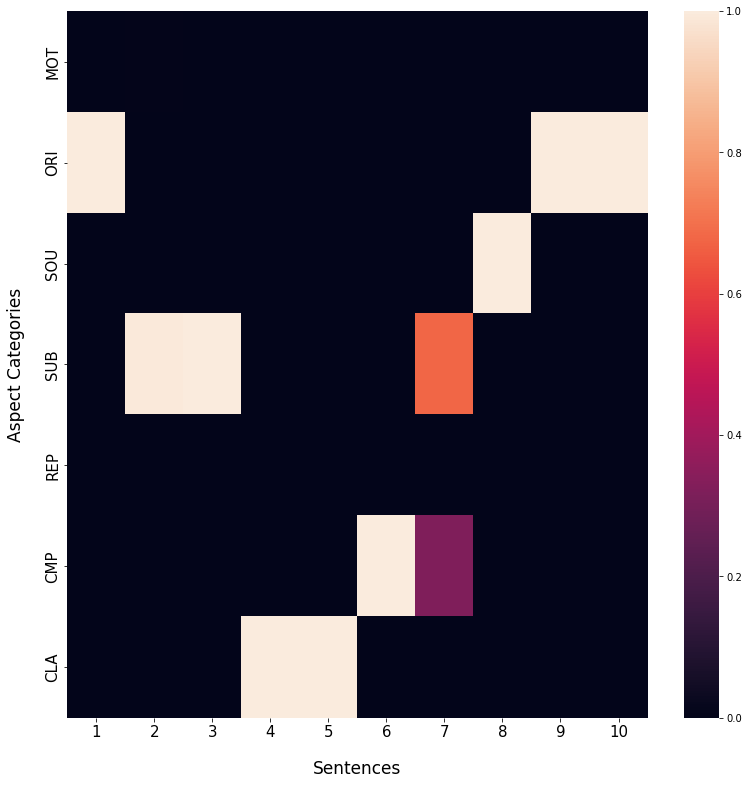

In [ ]:
# cm_plotAttention(cm_matrix2 , 'Rewiew 2', 'Greens')
cm_plotAttention(cm_matrix2 , 'Rewiew 2', 'rocket')